In [156]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

seed = 42

# Carga de datos

Para el presente ejercicio se utilizarán las siguientes categorías de productos anotados de reviews de Amazon:
- Clothing
- Office products
- Video games

Fuente de datos: http://jmcauley.ucsd.edu/data/amazon/

In [73]:
datasets_path = '../datasets'

clothing_json = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
office_json = 'reviews_Office_Products_5.json.gz'
videogames = 'reviews_Video_Games_5.json.gz'

In [34]:
df_office = pd.read_json(os.path.join(datasets_path, office_json), lines=True, compression='gzip')
df_clothing = pd.read_json(os.path.join(datasets_path, clothing_json), lines=True, compression='gzip')
df_videogames = pd.read_json(os.path.join(datasets_path, videogames), lines=True, compression='gzip')

# Trabajamos con la review (texto) y el overall (rating, o número de estrellas)

In [35]:
df_clothing = df_clothing.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
df_office = df_office.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
df_videogames = df_videogames.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]

In [37]:
df_clothing.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


# Normalizamos el número de estrellas

En función del número de estrellas las reviews serán etiquetadas como
- **Negativas** (0): 1 ó 2 estrellas
- **Positivas** (1): 4 ó 5 estrellas
- **Neutrales** (2): 3 estrellas

In [38]:
df_clothing.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_clothing['overall']]
df_office.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_office['overall']]
df_videogames.loc[:, 'sentiment'] = [0 if rank < 3 else 1 if rank > 3 else 2 for rank in df_videogames['overall']]

# Trabajamos con un subset de cada corpus

Balancear el dataset con respecto a la variable objetivo nos ayudará a obtener mejores resultados

In [52]:
n_reviews_per_sentiment = 2500

df_clothing = df_clothing.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_office = df_office.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_videogames = df_videogames.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))

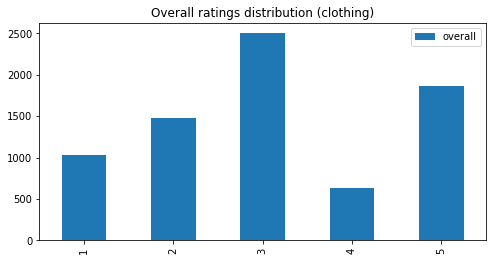

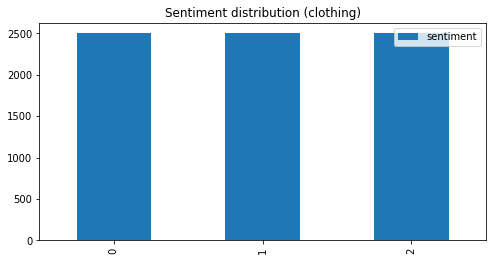

In [53]:
aux = pd.DataFrame(df_clothing['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (clothing)', figsize=(8, 4))

aux = pd.DataFrame(df_clothing['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (clothing)', figsize=(8, 4))

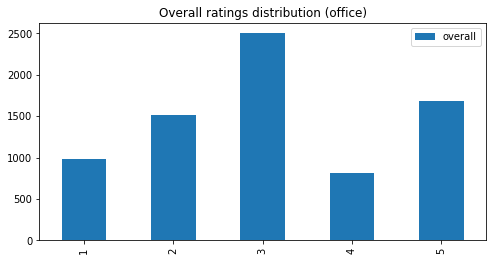

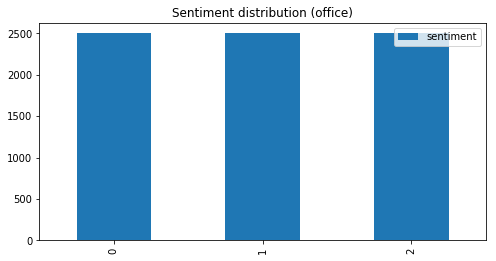

In [54]:
aux = pd.DataFrame(df_office['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (office)', figsize=(8, 4))

aux = pd.DataFrame(df_office['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (office)', figsize=(8, 4))

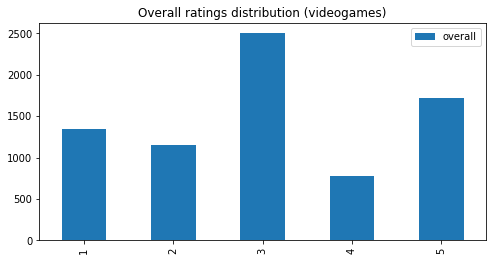

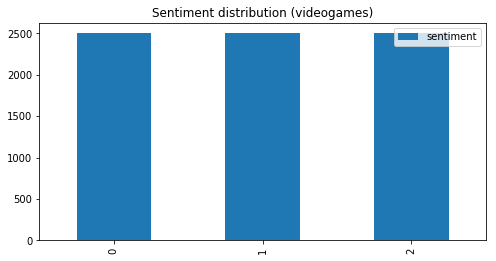

In [55]:
aux = pd.DataFrame(df_videogames['overall'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall ratings distribution (videogames)', figsize=(8, 4))

aux = pd.DataFrame(df_videogames['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Sentiment distribution (videogames)', figsize=(8, 4))

# Juntamos los tres DataFrames en uno

In [56]:
df = pd.concat([df_clothing, df_office, df_videogames])

In [57]:
df.shape

(22500, 3)

# Pruebas con VADER (Valence Aware Sentiment Dictionary and sEntiment Reasoner)

In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [61]:
vader_analyser = SentimentIntensityAnalyzer()

Seleccionamos al azar reviews de etiquetadas como negativo, positivo o neutro.

Modificando el filtro `(df['sentiment']==0)` podemos seleccionar la categoría deseada.

El `compound` representa la polaridad e intensidad del sentimiento inferido de la review.

In [72]:
review_test = df[df['sentiment']==0].sample(1)['reviewText'].values[0]
print(review_test)
print(vader_analyser.polarity_scores(review_test))

First off, the only reason I bought this EP was because of all the good reviews it got.There's really nothing good about this EP. I have to say it's probably the worst that Maxis ever put out. I change families and my kids grow up fast; I don't need 325 Mr. Humbles showing up at the door, nor do I desire to have countless popups of "gained" and "lost" enthusiasm in hobbies, which lead to "secret hobby lots" which are basically smaller versions of community lots and your access to them can be denied once your hobby levels drop.The only things I like are the new cribs and nursery sets for toddlers and the bohemian and ballet outfits for our girls.Yuck... I want to sell my copy now.
{'neg': 0.099, 'neu': 0.817, 'pos': 0.084, 'compound': -0.4665}


## Conclusiones al usar VADER

Puede observarse como el uso de VADER es muy sencillo gracias a la librería _vaderSentiment_. Al realizar algunas pruebas (ejcutando la celda anterior distintas veces para las distintas categorías) puede observarse como si bien a veces el resultado es correcto, en general no es demasiado preciso.

Además, la única manera de poder ajustar su funcionamiento sería mediante la edición del lexicon, tarea que no tiene sentido realizar existiendo alternativas mucho más eficaces y realizables como son las basadas en modelos de aprendizaje automático.

# Procesamos el texto

Implementación de la etapa de procesado similar a la del ejercicio 1-Topic Modeling

In [107]:
import re
import unicodedata
from stop_words import get_stop_words

In [99]:
def sentence_normalization(sentence):
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    sentence = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in sentence.split()])).strip()
    return sentence

In [100]:
def remove_stopwords(sentence, sw_list):
    sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
    return sentence

In [101]:
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

In [102]:
def lemmatize(sentence, lemmas_dict):
    sentence = ' '.join([lemmas_dict.get(word, word) for word in sentence.split()])
    return sentence

In [103]:
lemmas_path = '../data'
english_lemmas = 'lemmatization-en.txt'  # Fuente: https://github.com/michmech/lemmatization-lists

english_lemmas_dict = get_lemmas_dict(lemmas_path, english_lemmas)
english_lemmas_dict.get('running')

'run'

In [105]:
# Stop words
sw_list = get_stop_words('en')
sw_list[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [109]:
processed_sentences = []

for sent in df['reviewText']:
    sent = sentence_normalization(sent)
    sent = remove_stopwords(sent, sw_list)
    sent = lemmatize(sent, english_lemmas_dict)
    processed_sentences.append(sent)

In [110]:
df['processed_review'] = processed_sentences

In [111]:
df.head()

,reviewText,overall,sentiment,processed_review
263543,i imagined more color and the pearls to seem a...,2,0,imagine color pearl seem little little every t...
35253,"I like Haggar, but really I am not real keen o...",2,0,like really real keen expandable make good qua...
137895,"I should have returned it, but I washed it alr...",2,0,return wash gather area back
186096,Update: After a little less than a year the va...,1,0,little little year vamp tear join real shame s...
14671,I bought these thinking that I was getting the...,2,0,buy think get well slipper ugg name another pa...


In [112]:
print('Raw review:\n{}\n\n'.format(df['reviewText'].iloc[100]))
print('Processed review:\n{}'.format(df['processed_review'].iloc[100]))

Raw review:
I love the Keen Bali and they are hard to find on sale.  I tried these and returned them as they were too tight on my high instep.


Processed review:
love keen bali hard find try return tight high


# Definimos los siguientes experimentos para el entrenamiento y validación de modelos de clasificación de reviews de Amazon en función del sentimiento inferido en ellos

La representación de las reviews la realizaremos vectorizando los documentos con el TfidfVectorizer

- Modelo de **clasificación binaria** (reviews positivas y negativas) **sin procesado de texto**
- Modelo de **clasificación binaria** (reviews positivas y negativas) **con procesado de texto**
- Modelo de **clasificación binaria** (reviews positivas y negativas) **con procesado de texto** y **algunos parámetros configurados en el vectorizer**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **sin procesado de texto**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **con procesado de texto**
- Modelo de **clasificación multi**-clase (reviews positivas, negativas y neutras) **con procesado de texto** y **algunos parámetros configurados en el vectorizer**

Para todos los experimentos se entrenarán los mismos modelos, con igual política de búsqueda de hiperparámetros y mismos porcentajes para train y test.

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [191]:
def get_classification_sentiment_model_results(
    reviews,
    sentiment,
    max_df=1.00,
    min_df=1,
    max_features=None,
    ngram_range=(1, 1),
    multi=False,
    visualize=False
):

    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        reviews,
        sentiment,
        train_size=0.75,
        test_size=0.25,
        random_state=seed,
        shuffle=True,
        stratify=sentiment
    )
    
    # Extracción de características (matriz documento-término de scores TF-IDF)
    cv = TfidfVectorizer()
    cv.fit(X_train)
    X_train_ = cv.transform(X_train)
    X_test_ = cv.transform(X_test)
    
    train_acc = []
    test_acc = []
    if not multi:  # Clasificación binaria
        # Tunning sobre una Logistic Regression
        c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]
        lr_models = []

        for c in c_params:
            lr = LogisticRegression(C=c, solver='lbfgs', max_iter=3000)
            lr.fit(X_train_, y_train)

            train_predict = lr.predict(X_train_)
            test_predict = lr.predict(X_test_)
            train_acc.append(accuracy_score(y_train, train_predict))
            test_acc.append(accuracy_score(y_test, test_predict))
            lr_models.append(lr)
            
        # Predecir con el modelo "óptimo"
        lr_ = lr_models[np.argmax(test_acc)]
        test_predict = lr_.predict(X_test_)

    else:  # Clasificación multi-clase, sin hyperparameter tunning
        mnb_model = MultinomialNB()
        mnb_model.fit(X_train_, y_train)
        test_predict = mnb_model.predict(X_test_)
    
    # Visualizar resultados
    if visualize and not multi:
        plt.figure(figsize=(12, 8))
        plt.plot(train_acc, label='train')
        plt.plot(test_acc, label='test')
        plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
        plt.title('Accuracy evolution for different C values')
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.xticks(list(range(len(c_params))), c_params)
        plt.tight_layout()
        plt.show()
    
    
    # Confusion matrix, classification report y accuracy score para el clasificador "óptimo"
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

## Sin procesado de texto + Clasificación binaria

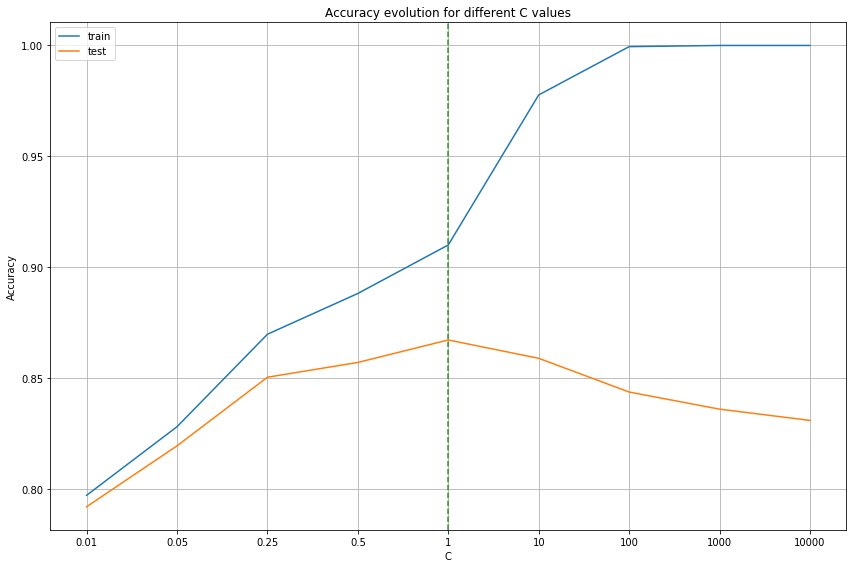

Confussion matrix:
[[1636  239]
 [ 259 1616]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1875
           1       0.87      0.86      0.87      1875

    accuracy                           0.87      3750
   macro avg       0.87      0.87      0.87      3750
weighted avg       0.87      0.87      0.87      3750

Accuracy score:0.8672


In [192]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['reviewText'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    multi=False,
    visualize=True
)

## Con procesado de texto + Clasificación binaria

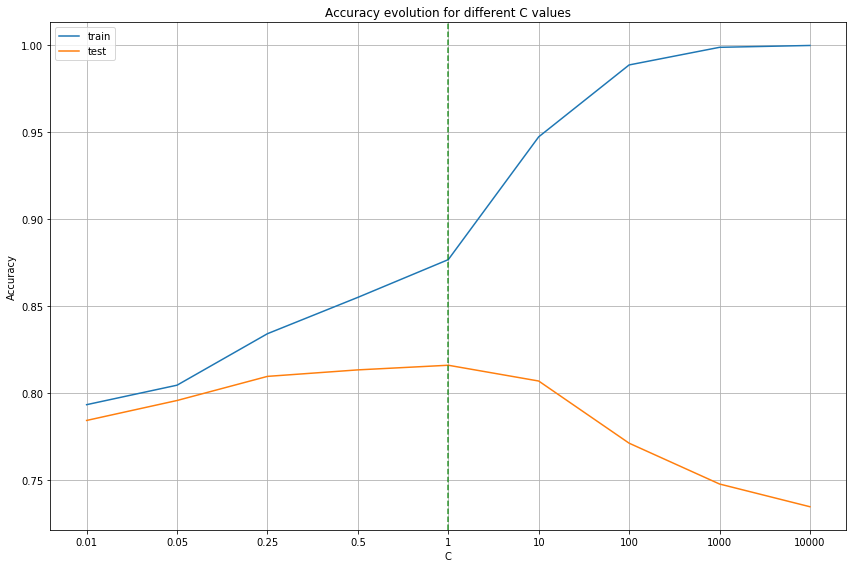

Confussion matrix:
[[1522  353]
 [ 337 1538]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1875
           1       0.81      0.82      0.82      1875

    accuracy                           0.82      3750
   macro avg       0.82      0.82      0.82      3750
weighted avg       0.82      0.82      0.82      3750

Accuracy score:0.816


In [193]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['processed_review'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    multi=False,
    visualize=True
)

## Con procesado de texto + Clasificación binaria + Tunning TfidfVectorizer

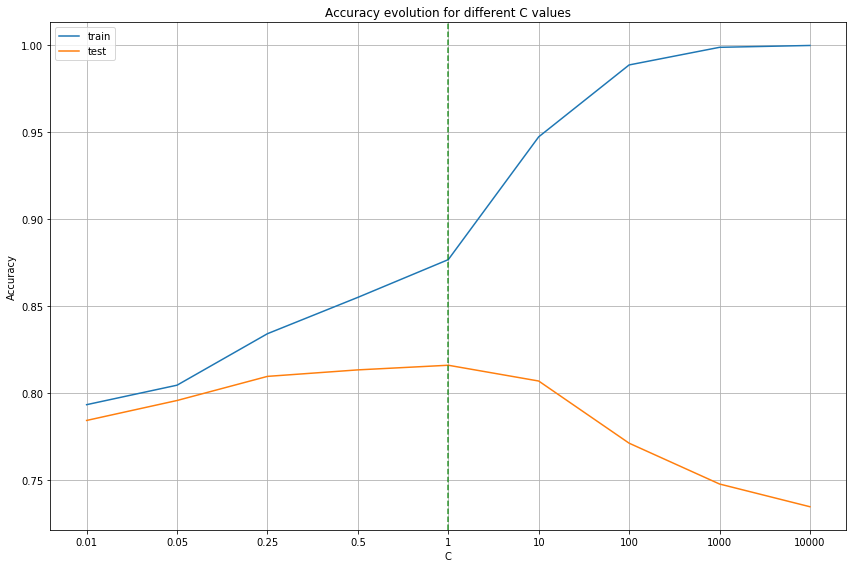

Confussion matrix:
[[1522  353]
 [ 337 1538]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1875
           1       0.81      0.82      0.82      1875

    accuracy                           0.82      3750
   macro avg       0.82      0.82      0.82      3750
weighted avg       0.82      0.82      0.82      3750

Accuracy score:0.816


In [194]:
get_classification_sentiment_model_results(
    reviews=df[df['sentiment'] != 2]['processed_review'],
    sentiment=df[df['sentiment'] != 2]['sentiment'],
    max_df=0.95,
    min_df=15,
    max_features=3000,
    ngram_range=(2, 3),
    multi=False,
    visualize=True
)

## Sin procesado de texto + Clasificación multi-clase

In [195]:
get_classification_sentiment_model_results(
    reviews=df['reviewText'],
    sentiment=df['sentiment'],
    multi=True,
    visualize=True
)

Confussion matrix:
[[1060   84  731]
 [ 166  968  741]
 [ 384  195 1296]]

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1875
           1       0.78      0.52      0.62      1875
           2       0.47      0.69      0.56      1875

    accuracy                           0.59      5625
   macro avg       0.63      0.59      0.60      5625
weighted avg       0.63      0.59      0.60      5625

Accuracy score:0.5909333333333333


## Con procesado de texto + Clasificación multi-clase

In [196]:
get_classification_sentiment_model_results(
    reviews=df['processed_review'],
    sentiment=df['sentiment'],
    multi=True,
    visualize=True
)

Confussion matrix:
[[1020  151  704]
 [ 227  967  681]
 [ 433  303 1139]]

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1875
           1       0.68      0.52      0.59      1875
           2       0.45      0.61      0.52      1875

    accuracy                           0.56      5625
   macro avg       0.58      0.56      0.56      5625
weighted avg       0.58      0.56      0.56      5625

Accuracy score:0.5557333333333333


## Con procesado de texto + Clasificación multi-clase + Tunning TfidfVectorizer

In [197]:
get_classification_sentiment_model_results(
    reviews=df['processed_review'],
    sentiment=df['sentiment'],
    max_df=0.95,
    min_df=15,
    max_features=3000,
    ngram_range=(2, 3),
    multi=True,
    visualize=True
)

Confussion matrix:
[[1020  151  704]
 [ 227  967  681]
 [ 433  303 1139]]

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1875
           1       0.68      0.52      0.59      1875
           2       0.45      0.61      0.52      1875

    accuracy                           0.56      5625
   macro avg       0.58      0.56      0.56      5625
weighted avg       0.58      0.56      0.56      5625

Accuracy score:0.5557333333333333


# Conclusiones

La presente solución es solo una propuesta de las múltiples opciones que había para resolver el ejercicio.

Para la clasificación binaria se ha entrenado una Regresión Logística. Para el problema multi-clase se ha entrenado un clasificador Multinomial Naive Bayes.

De los resultados podemos obtener algunas conclusiones:
- La clasificación binaria arroja mejores resultados que la clasificación multi-clase. Algo esperable pero que queda demostrado
- El preprocesado de texto no necesariamente redunda en mejores resultados. Aunque en general ayuda, en los resultados obtenidos de los resultados de los experimentos realizados se puede ver como aquellos modelos entrenados sin procesar el texto son mejores trabajando con el texto en crudo. Para ello se utiliza, principalmente, el macro avg f1-score como figura de mérito a comparar entre modelos
- En la clasificación binaria no parece haber grandes diferencias en las métricas a la hora de predecir reviews como positivas o negativas. Podemos determinar que el balanceo de clases ha permitido que el modelo generalice de manera uniforme entre ambas clases
- En cambio, para la clasificación multi-clase, las métricas por clase son bastante desiguales. En general el accuracy es mayor para la clase "positiva" y menor para las "neutrales". En cambio, el recall para estas últimas es el mayor de todas las clases. Pese a esto, los resultados son potencialmente mejorables ya que no son métricas que permitan determinar que ninguno de los tres es un buen modelo.

Además del procesado del dato y enrtenamiento de modelos que se presenta en este notebook, otras opciones a considerar a la hora de abordar este retro podrían ser:
- La etiquetación de las reviews como positivas, negativas y neutras ha sido directa, sin realizar ningún tipo análisis en dicha segmentación. Diferentes estrategias pueden plantearse a la hora de definir umbrales en el número de estrellas (en este caso) y su correspondencia con la categoría sentimiento. Una posibilidad puede ser el análisis de la distribución de la frecuencia de aparición de distintas categorías gramaticales por número de estrellas.
- Procesado de texto más complejo. Desambiguación en la lemmatización, confección de una lista de stop words y no usar una por defecto, eliminación de URLs o direcciones de correo, etc.
- Extracción de características como la longitud de la review, las categorías gramaticales presentes (y su presencia), la inclusión de determinadas palabras (altamente correladas con el target) como posibles categorías (Term Presence) de manera que su presencia (o ausencia) facilite el reconocimiento por parte del clasificador...
- Tunning de lo parámetros del vetorizer para tratar de encontrar la combinación que maximice los resultados
- Uso de word embeddings como features para el entrenamiento del clasificador
- Entrenamiento de otros tipo de clasificadores (Random Forest Classifier, SVM, Redes Neuronales...) de manera que se pueda encontrar un modelo para el que, dado un procesado de datos, funcione mejor que el resto
- Pruebas, para este caso de uso, de otros modelos de análisis de sentimiento pre-entrenados